# Caso grupal: Usos reales de filtros espaciales y morfológicos
Percepción computacional

# Integrantes del grupo

Grupo del Laboratorio: 10 

Grupo de estudios: 12 - FUNDAE

Listado de integrantes:
- Beatriz Garcia Collado
- Manuel Naranjo Martínez
- Óscar Martínez Olmos
- Pablo David Lombardo Papi
- Santiago Félix Eslava Ros


# Opciones planteadas

Durante las reuniones iniciales del grupo se plantearon diferentes posibilidades de proyectos y una aproximación a cada una de ellas. Una vez debatidas se elegiría la más interesante.

El proyecto elegido fue el de Detección de zona de matrícula en imágenes con coches.

A continuación se muestran algunos de los otros ejemplos planteados:

- Implementación desde cero de un algoritmo de paso bajo

- Degradación de imagen

Se prentedía, sin usar filtros preprogramados, realizar una degradación de imagen para simular el efecto de ser dibujado a lapiz. El metodo ha sido manipular la imagen a partir de una función Gauss y restar su resultado a la imagen original en escala de grises.

![lapiz](lapiz.png)

- Tratamiento de imagenes sobre tramas urbanas

Se pretendería tratar imagenes de una ciudad vista desde arriba, ya sea por imagenes satélite o aéreas desde avión, para facilitar la identifición del tipo de trama urbana o planeamiento urbano que tienen.

![Tratamiento de imagen satelital](opcion_satelite.png)



# Proyecto: Detección de zona de matrícula

A partir de fotos realizadas a coches donde se puede ver la matrícula, se pretende hacer un filtrado de la imagen para obtener la localización de las posibles zonas que corresponden a la matrícula que hay en la imagen. También, se pretende realizar una serie de operaciones que facilicen a un posible programa de reconocimiento de texto la lectura de ellas. Nos basamos en el artículo de detección de matrículas (Anagnostopoulos, 2006) incorporando una nueva metodología para mejorar la detección.

Objetivos base:
- Limpiar la imagen del coche para eliminar elementos innecesarios en la detección.
- Extraer la zona de la matrícula de una imagen


# Importación de librerías

In [1]:
# Para realizar operacione sobre matrices
import numpy as np
# Para procesar las imágenes
from skimage import data, filters, feature, io, morphology, util, measure
# Para mostrar las imágenes
import matplotlib.pyplot as plt
# Paquetes necesarios para la conversion de imágenes de color a escala de grises
from skimage.color import rgb2gray
# Paquetes necesarios para la morfologia matemática
from skimage.morphology import erosion, dilation, opening, closing
# Elementos estructurales
from skimage.morphology import disk, diamond, ball, rectangle, square
# Rellenado de agujeros
from scipy import ndimage as ndi

# Definición de funciones a utilizar

In [2]:
def plot_comparison_3imagesContours(img_l, img_m, img_r, r_title, m_title, l_title, contours=None):
    """
    Función para mostrar dos imágenes en paralelo para compararlas
    
    Args:
        img_l (Numpy Array): Imagen de la izq.
        img_m (Numpy Array): Imagen del medio
        img_r (Numpy Array): Imagen de la derecha
        contours (Numpy Array): Contorno de la matrícula
        
        r_title (String): Título de la imagen de la izq
        m_title (String): Título de la imagen central
        l_title (String): Título de la imagen de la der
        
    """
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 20), sharex=True,
                                  sharey=True)
    
    ax1.imshow(img_l, cmap=plt.cm.gray)
    ax1.set_title(r_title)
    ax1.axis('off')
    ax1.set_adjustable('box')
    ax2.imshow(img_m, cmap=plt.cm.gray)
    ax2.set_title(m_title)
    ax2.axis('off')
    ax2.set_adjustable('box')
    ax3.imshow(img_r, cmap=plt.cm.gray)
    ax3.set_title(l_title)
    ax3.axis('off')
    ax3.set_adjustable('box')
    if contours is not None:
        for contour in contours:
            ax3.plot(contour[:, 1], contour[:, 0], 'g', linewidth=5)
    plt.show()

def plot_comparison(img_l, img_r, r_title, l_title):
    """
    Función para mostrar dos imágenes en paralelo para compararlas
    
    Args:
        img_l (Numpy Array): Imagen de la izq.
        img_r (Numpy Array): Imagen de la derecha
        
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20), sharex=True,
                                  sharey=True)
    
    ax1.imshow(img_l, cmap=plt.cm.gray)
    ax1.set_title(r_title)
    ax1.axis('off')
    ax1.set_adjustable('box')
    ax2.imshow(img_r, cmap=plt.cm.gray)
    ax2.set_title(l_title)
    ax2.axis('off')
    ax2.set_adjustable('box')
    plt.show()

def exponential(img, alpha=750):
    """
    Función exponencial para reducir sobreexposición
    
    Args:
        img (Numpy Array): Imagen sobre la que aplicar el filtro exponencial
        alpha (Int): Factor de aplicación de la función expo.
    """
    X = img/255.0 # Normalizamos valores
    
    max_r = np.max(X, axis= (0,1)) # Tupla con los máximos de todos los canales
    max_s = np.array([1.0, 1.0, 1.0])
    
    c = max_s / ((1+alpha)**max_r-1)
    Y = c*((1+alpha)**X-1)
        
    return Y

# 
def filtrosrectangle(imagen):
    """
    Filtro morfológico para eliminar los elementos 
    cuyo ancho sea menor que el de la matrícula
    
    Args:
        image (Numpy Array): Imagen sobre la que aplicar los filtros
        
    Return:
        Numpy Array: Imagen con los filtros aplicados
    """
    im2 = morphology.erosion(image=imagen, selem=rectangle(1, 30))
    im3 = morphology.remove_small_objects(im2, 15) # Eliminar objeto con area menor a 15 pixeles
    im4 = morphology.dilation(image=im3, selem=rectangle(1, 15))
    
    return(im4)

# Detección de zona de matrícula

## Lectura y preprocesado
Leemos la imagen y le aplicamos una función exponencial para reducir zonas sobreexpuestas.
Después la convertimos a escala de grises para aplicar los filtros.

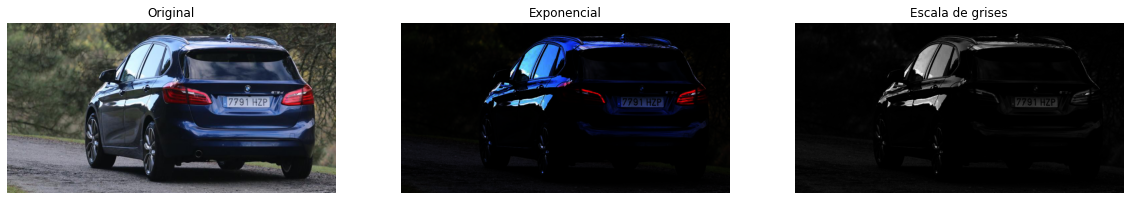

In [3]:
# Leemos imagen y convertimos a escala de grises
image_name = 'matricula3.jpg'
lp = plt.imread(image_name)#.astype('double')/255

lp_exp = exponential(lp, alpha=750)

lp_gray = rgb2gray(lp_exp)

# comparamos img original e img con escala de grises
plot_comparison_3imagesContours(lp, lp_exp, lp_gray, 'Original', 'Exponencial', 'Escala de grises')

## Aplicación de filtros

* 1. Filtro temporal para detección de bordes
* 2. Umbralización para binarizar la imagen
* 3. Filtros morfológicos sucesivos para eliminar detalles innecesarios e intentar quedarnos solo con la zona de la matrícula.

In [7]:
# filtro paso alto para detección de bordes
im_borders = feature.canny(lp_gray)

# Umbralización de la imagen
threshold = filters.threshold_otsu(im_borders)
im_binary= im_borders > threshold

### Elección de posibles máscaras de matrícula
Aplicación de los filtros morfológicos indicados en el punto 3.
- Se aplican dos primeros filtros morfológicos para eliminar los contornos de la silueta del coche.
- Se cuentan la cantidad de contornos que existen en la imagen y se aplica en loop los filtros morfológicos
  para eliminar las áreas que no sean rectangulares hasta que quede un único contorno.

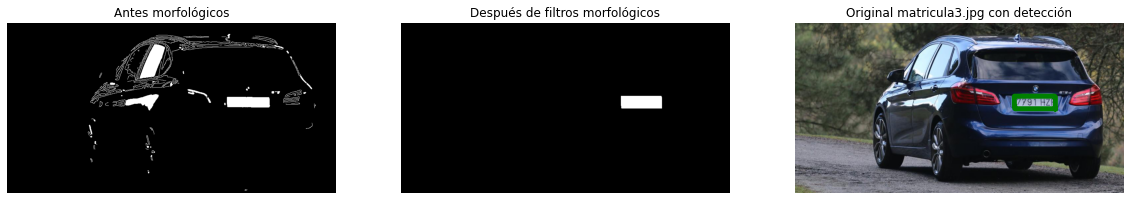

In [5]:
# Rellenamos los agujeros
im_holed = ndi.binary_fill_holes(im_binary)

# Aplicamos filtros morfológicos rectangulares para ir eliminado o ensanchando zonas de líneas 
# o recuadros.
im0 = morphology.erosion(image=im_holed, selem=rectangle(7,5))
im1 = morphology.remove_small_objects(im0, 9)

#consultamos cuantas posibles areas o contornos podrían alojar la matrícula
contours = measure.find_contours(im1, 0.5)

# iteramos filtros rectangulo para elimiar todos los elementos inferiores en ancho al de la matícula.
imin=im1
n=0
while len(contours)>1:
    imout=filtrosrectangle(imin)
    contours = measure.find_contours(imout, 0.5)
    imin=imout
    n+=1
    
# Dilatamos de forma proporcional al número de veces que hemos erosionado en el while
# para recuperar las dimensiones originales de la matrícula
if n>0:
    imout=morphology.dilation(image=imout, selem=rectangle(15, n*15))
else:
    imout=morphology.dilation(image=imin, selem=rectangle(15, 15))

# Dibujamos el contorno de la matrícula en la imagen original

imend=imout.copy()
contours = measure.find_contours(imend, 0.5)  
plot_comparison_3imagesContours(im_holed, imout, lp, 
                                "Antes morfológicos", 
                                "Después de filtros morfológicos", 
                                "Original " + image_name + " con detección", 
                                contours)

## Problemas encontrados

* Dificultad en los casos de los coches blancos o en posiciones con altos contrastes del entorno
    - Resuelto, en cierta medida. mediante la aplicación del la función exponencial
    - Contornos rectangulares de dimensiones superiores a la matrícula con fondo blanco (ej. matricula10.jpg)  

# Resultados de otros ejemplos

A continuación se pueden ver las imagenes resultados del mismo algoritmo ejecutado sobre otros ejemplos:

![Matrícula 1](resultado1.png)
![Matrícula 2](resultado2.png)
![Matrícula 3](resultado3.png)
![Matrícula 4](resultado4.png)
![Matrícula 5](resultado5.png)
![Matrícula 6](resultado6.png)
![Matrícula 7](resultado7.png)
![Matrícula 8](resultado8.png)
![Matrícula 9](resultado9.png)
![Matrícula 10](resultado10.png)
![Matrícula 11](resultado11.png)








#  Conclusiones

- Una serie de filtros para el tratamiento de imagenes pueden ser suficientes para localizar zonas concretas de forma automática
- Se ha comprobado que se necesita una gran capacidad de computo incluso para imagenes pequeñas por lo que durante el proyecto se han intentado reducir al mínimo los filtros ejecutados por el algoritmo.
- Incluso para imagenes que se podrían pensar conflictivas, como con coches blancos o reflejos de luces, se han podido introducir otros filtos que corregian la imagen para que mejorara su procesamiento.
- Hemos comprobado que se obtiene un buen comportamiento en todas las imagenes tratadas

#  Referencias

* C. N. E. Anagnostopoulos, I. E. Anagnostopoulos, V. Loumos and E. Kayafas, "A License Plate-Recognition Algorithm for Intelligent Transportation System Applications," in IEEE Transactions on Intelligent Transportation Systems, vol. 7, no. 3, pp. 377-392, Sept. 2006, doi: 10.1109/TITS.2006.880641.